# 📚 Week 6.1: Classification Methods for Quantitative Finance

---

## 🎯 Learning Objectives

This week covers **classification methods** essential for trading signal generation:

| Day | Topic | Key Concepts |
|-----|-------|--------------|
| 1 | Logistic Regression | Sigmoid function, log-odds, MLE |
| 2 | Support Vector Machines | Margin maximization, kernels |
| 3 | Triple Barrier Method | Event-based labeling |
| 4 | Meta-Labeling | Bet sizing, secondary model |
| 5 | Multiclass Classification | One-vs-rest, softmax |
| 6 | Class Imbalance | SMOTE, class weights |
| 7 | Interview Review | Practice questions |

---

In [1]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Sample data
ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=756)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
returns = data['Close'].pct_change().dropna()
print(f"✅ Loaded {len(returns)} trading days")

📥 Downloading data...
✅ Loaded 516 trading days


---

# 📊 Day 1: Logistic Regression

## Theory

**Logistic Regression** models the probability of a binary outcome using the **sigmoid function**:

$$P(Y=1|X) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z = \beta_0 + \beta_1 X_1 + ... + \beta_n X_n$

### Log-Odds (Logit)

$$\log\left(\frac{P}{1-P}\right) = \beta_0 + \beta_1 X_1 + ... + \beta_n X_n$$

### Maximum Likelihood Estimation (MLE)

The likelihood function:
$$L(\beta) = \prod_{i=1}^{n} p_i^{y_i}(1-p_i)^{1-y_i}$$

Log-likelihood:
$$\ell(\beta) = \sum_{i=1}^{n} [y_i \log(p_i) + (1-y_i)\log(1-p_i)]$$

### Financial Application
- Predict UP (1) vs DOWN (0) market moves
- Probability output useful for position sizing
- Coefficients show feature importance

---

📊 LOGISTIC REGRESSION RESULTS

Accuracy: 59.33%

Coefficients:
   lag_1: +0.1893
   lag_2: +0.1184
   lag_5: +0.0371
   vol_5: -0.1863
   vol_20: +0.2405
   momentum_10: -0.1079


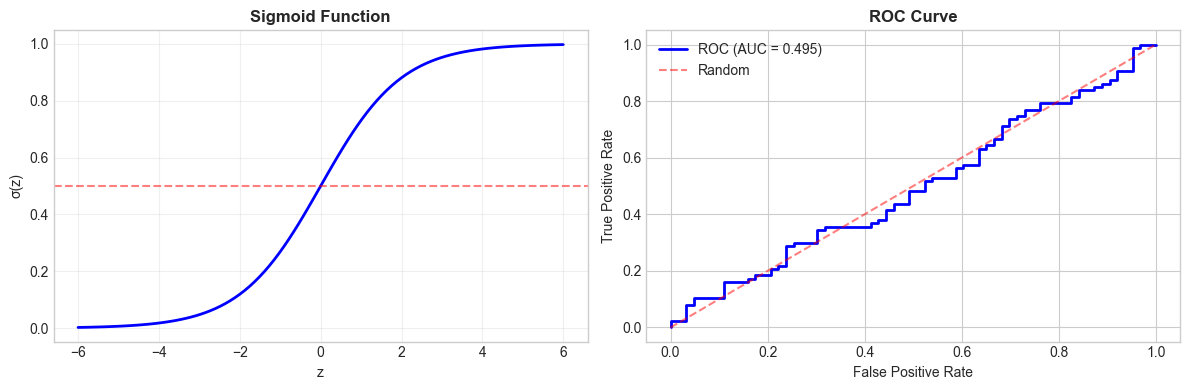

In [2]:
# ============================================================
# DAY 1: LOGISTIC REGRESSION
# ============================================================

# Create features and labels
df = pd.DataFrame(index=returns.index)
df['return'] = returns
df['lag_1'] = returns.shift(1)
df['lag_2'] = returns.shift(2)
df['lag_5'] = returns.shift(5)
df['vol_5'] = returns.rolling(5).std()
df['vol_20'] = returns.rolling(20).std()
df['momentum_10'] = data['Close'].pct_change(10)
df['label'] = (returns.shift(-1) > 0).astype(int)  # Next day UP/DOWN
df = df.dropna()

# Prepare data
features = ['lag_1', 'lag_2', 'lag_5', 'vol_5', 'vol_20', 'momentum_10']
X = df[features]
y = df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print("📊 LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(f"\nAccuracy: {(y_pred == y_test).mean():.2%}")
print(f"\nCoefficients:")
for feat, coef in zip(features, log_reg.coef_[0]):
    print(f"   {feat}: {coef:+.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Sigmoid function
ax1 = axes[0]
z = np.linspace(-6, 6, 100)
sigmoid = 1 / (1 + np.exp(-z))
ax1.plot(z, sigmoid, 'b-', linewidth=2)
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('z')
ax1.set_ylabel('σ(z)')
ax1.set_title('Sigmoid Function', fontweight='bold')
ax1.grid(True, alpha=0.3)

# ROC Curve
ax2 = axes[1]
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

---

# 📊 Day 2: Support Vector Machines (SVM)

## Theory

**SVM** finds the hyperplane that maximizes the **margin** between classes.

### Linear SVM Optimization

$$\min_{w,b} \frac{1}{2}||w||^2$$

Subject to: $y_i(w \cdot x_i + b) \geq 1$ for all $i$

### Soft Margin (C parameter)

$$\min_{w,b,\xi} \frac{1}{2}||w||^2 + C\sum_{i=1}^{n}\xi_i$$

- **C large:** Smaller margin, fewer misclassifications
- **C small:** Larger margin, more tolerant of errors

### Kernel Trick

Transform data to higher dimensions:
- **Linear:** $K(x_i, x_j) = x_i \cdot x_j$
- **RBF:** $K(x_i, x_j) = \exp(-\gamma||x_i - x_j||^2)$
- **Polynomial:** $K(x_i, x_j) = (x_i \cdot x_j + r)^d$

### Financial Application
- Non-linear decision boundaries for complex patterns
- Works well with high-dimensional feature spaces
- Robust to outliers with soft margin

---

📊 SVM KERNEL COMPARISON

LINEAR Kernel:
   Test Accuracy: 58.00%
   CV Accuracy: 58.15% ± 0.39%

RBF Kernel:
   Test Accuracy: 58.00%
   CV Accuracy: 56.55% ± 2.91%

POLY Kernel:
   Test Accuracy: 58.00%
   CV Accuracy: 57.54% ± 0.52%


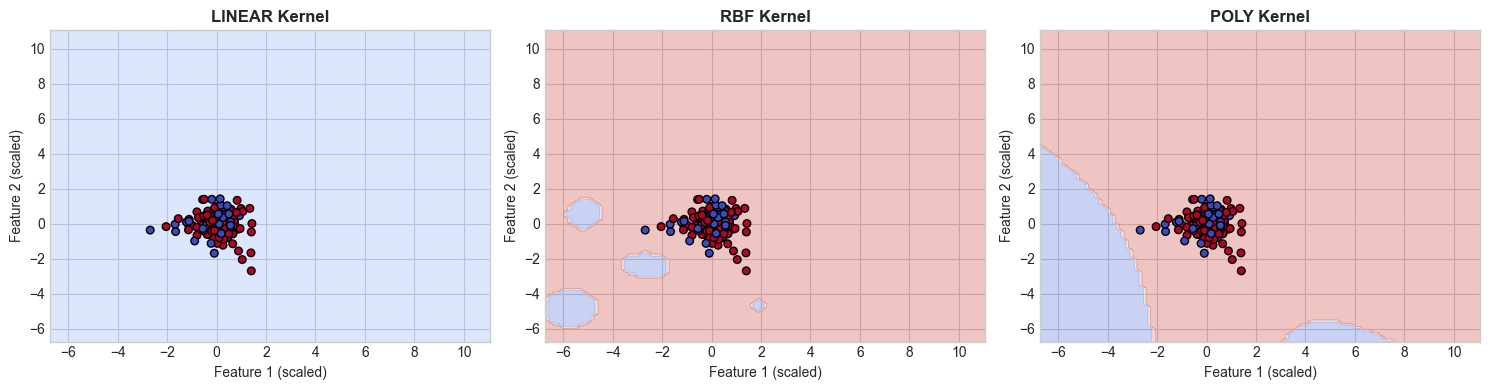

In [3]:
# ============================================================
# DAY 2: SUPPORT VECTOR MACHINES
# ============================================================

# Compare different kernels
kernels = ['linear', 'rbf', 'poly']
svm_results = {}

print("📊 SVM KERNEL COMPARISON")
print("=" * 60)

for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    accuracy = (y_pred_svm == y_test).mean()
    
    # Cross-validation
    cv_scores = cross_val_score(svm, X_scaled, y, cv=5, scoring='accuracy')
    
    svm_results[kernel] = {
        'model': svm,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"\n{kernel.upper()} Kernel:")
    print(f"   Test Accuracy: {accuracy:.2%}")
    print(f"   CV Accuracy: {cv_scores.mean():.2%} ± {cv_scores.std():.2%}")

# Visualize decision boundaries (2D projection)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, kernel in zip(axes, kernels):
    # Use first 2 features for visualization
    X_2d = X_scaled[:, :2]
    X_train_2d, X_test_2d, _, _ = train_test_split(X_2d, y, test_size=0.3, shuffle=False)
    
    svm_2d = SVC(kernel=kernel, random_state=42)
    svm_2d.fit(X_train_2d, y_train)
    
    # Create meshgrid
    xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min()-1, X_2d[:, 0].max()+1, 100),
                         np.linspace(X_2d[:, 1].min()-1, X_2d[:, 1].max()+1, 100))
    Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', s=30)
    ax.set_title(f'{kernel.upper()} Kernel', fontweight='bold')
    ax.set_xlabel('Feature 1 (scaled)')
    ax.set_ylabel('Feature 2 (scaled)')

plt.tight_layout()
plt.show()

---

# 📊 Day 3: Triple Barrier Method

## Theory

The **Triple Barrier Method** (Marcos Lopez de Prado) creates labels based on which barrier is touched first:

### Three Barriers:
1. **Upper Barrier (Take Profit):** Price rises by `pt` (profit taking)
2. **Lower Barrier (Stop Loss):** Price falls by `sl` (stop loss)
3. **Vertical Barrier (Time):** Maximum holding period `t_max`

### Labels:
- **+1 (BUY):** Upper barrier touched first
- **-1 (SELL):** Lower barrier touched first
- **0 (NEUTRAL):** Vertical barrier touched first

### Advantages:
- Event-driven labeling (not fixed horizon)
- Incorporates risk management (stop-loss)
- More realistic trading scenario
- Adjustable barriers based on volatility

---

📊 TRIPLE BARRIER LABELING

Label Distribution:
   +1 (Buy):      200 (39.4%)
   -1 (Sell):     122 (24.1%)
    0 (Neutral):  185 (36.5%)


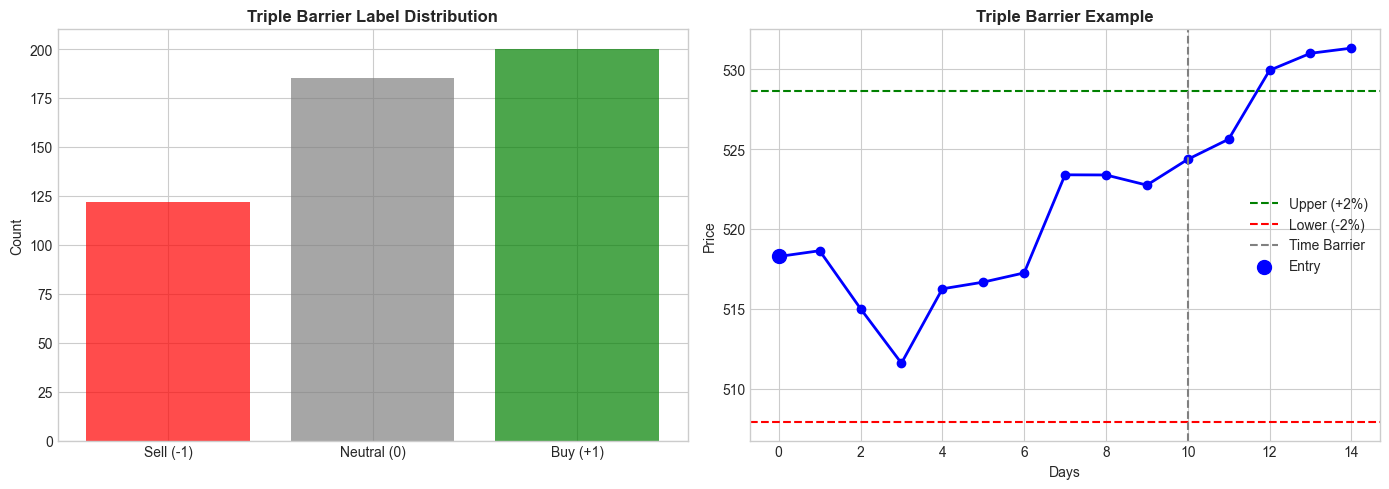

In [4]:
# ============================================================
# DAY 3: TRIPLE BARRIER METHOD
# ============================================================

def triple_barrier_label(prices, pt=0.02, sl=0.02, max_holding=10):
    """
    Triple barrier labeling method.
    
    Args:
        prices: Price series
        pt: Profit taking threshold (e.g., 0.02 = 2%)
        sl: Stop loss threshold
        max_holding: Maximum holding period in days
    
    Returns:
        Labels: +1 (up), -1 (down), 0 (neutral)
    """
    labels = pd.Series(index=prices.index, dtype=float)
    
    for i in range(len(prices) - max_holding):
        entry_price = prices.iloc[i]
        upper = entry_price * (1 + pt)
        lower = entry_price * (1 - sl)
        
        # Check future prices
        future_prices = prices.iloc[i+1:i+max_holding+1]
        
        # Find first barrier touch - handle scalar or series properly
        upper_mask = future_prices >= upper
        lower_mask = future_prices <= lower
        
        upper_touch = upper_mask.idxmax() if upper_mask.any() else None
        lower_touch = lower_mask.idxmax() if lower_mask.any() else None
        
        if upper_touch is None and lower_touch is None:
            labels.iloc[i] = 0  # Vertical barrier (time)
        elif upper_touch is None:
            labels.iloc[i] = -1  # Stop loss hit
        elif lower_touch is None:
            labels.iloc[i] = 1  # Take profit hit
        elif upper_touch <= lower_touch:
            labels.iloc[i] = 1  # Take profit first
        else:
            labels.iloc[i] = -1  # Stop loss first
    
    return labels

# Apply triple barrier - prices is a DataFrame, need to get the column
prices_series = data['Close'].squeeze() if isinstance(data['Close'], pd.DataFrame) else data['Close']
tb_labels = triple_barrier_label(prices_series, pt=0.02, sl=0.02, max_holding=10)
tb_labels = tb_labels.dropna()

print("📊 TRIPLE BARRIER LABELING")
print("=" * 60)
print(f"\nLabel Distribution:")
print(f"   +1 (Buy):    {(tb_labels == 1).sum():>5} ({(tb_labels == 1).mean():.1%})")
print(f"   -1 (Sell):   {(tb_labels == -1).sum():>5} ({(tb_labels == -1).mean():.1%})")
print(f"    0 (Neutral):{(tb_labels == 0).sum():>5} ({(tb_labels == 0).mean():.1%})")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Label distribution
ax1 = axes[0]
label_counts = tb_labels.value_counts().sort_index()
colors = ['red', 'gray', 'green']
ax1.bar(['Sell (-1)', 'Neutral (0)', 'Buy (+1)'], label_counts.values, color=colors, alpha=0.7)
ax1.set_ylabel('Count')
ax1.set_title('Triple Barrier Label Distribution', fontweight='bold')

# Example visualization
ax2 = axes[1]
sample_idx = 100
sample_price = prices_series.iloc[sample_idx]
future = prices_series.iloc[sample_idx:sample_idx+15]
ax2.plot(range(len(future)), future, 'b-', linewidth=2, marker='o')
ax2.axhline(y=sample_price * 1.02, color='green', linestyle='--', label='Upper (+2%)')
ax2.axhline(y=sample_price * 0.98, color='red', linestyle='--', label='Lower (-2%)')
ax2.axvline(x=10, color='gray', linestyle='--', label='Time Barrier')
ax2.scatter([0], [sample_price], color='blue', s=100, zorder=5, label='Entry')
ax2.set_xlabel('Days')
ax2.set_ylabel('Price')
ax2.set_title('Triple Barrier Example', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

---

# 📊 Day 4: Meta-Labeling

## Theory

**Meta-Labeling** is a two-stage approach:

### Stage 1: Primary Model
- Predicts direction (buy/sell signal)
- Focus on **recall** (catch all opportunities)

### Stage 2: Secondary Model (Meta-Labeler)
- Predicts whether to **act** on primary signal
- Focus on **precision** (filter false positives)
- Output: Probability → **bet sizing**

### Mathematical Framework

$$\text{Final Signal} = \text{Primary Signal} \times P(\text{Meta-Label} = 1)$$

### Advantages:
- Decouples direction prediction from bet sizing
- Allows different features for each model
- Improves risk-adjusted returns
- Reduces false positive trades

---

📊 META-LABELING RESULTS

Meta-Model Accuracy: 50.67%

Interpretation:
   - High probability → Strong conviction, larger position
   - Low probability → Weak conviction, smaller/no position

Position Sizing Example:
   Probability > 0.7: Full position (100%)
   Probability 0.5-0.7: Half position (50%)
   Probability < 0.5: No position (0%)


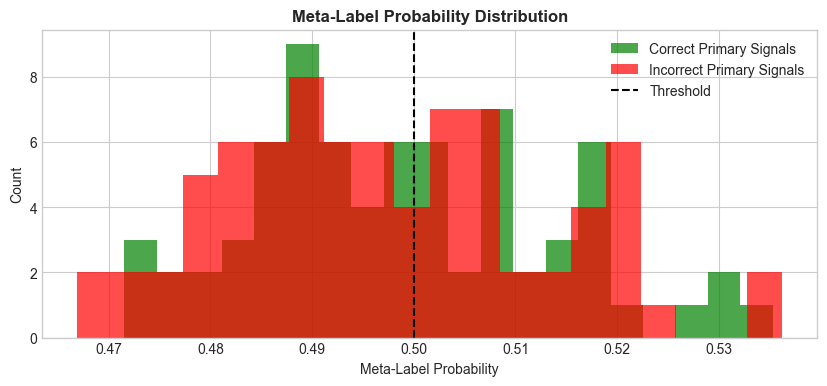

In [5]:
# ============================================================
# DAY 4: META-LABELING
# ============================================================

# Primary Model: Simple momentum signal
df['primary_signal'] = np.where(df['momentum_10'] > 0, 1, -1)

# Meta-label: Did the primary signal make money?
df['meta_label'] = ((df['primary_signal'] * df['return'].shift(-1)) > 0).astype(int)

# Prepare meta-labeling data
meta_features = ['lag_1', 'lag_2', 'vol_5', 'vol_20']
X_meta = df[meta_features].dropna()
y_meta = df['meta_label'].loc[X_meta.index]

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta, y_meta, test_size=0.3, shuffle=False
)

# Scale
scaler_meta = StandardScaler()
X_train_meta_scaled = scaler_meta.fit_transform(X_train_meta)
X_test_meta_scaled = scaler_meta.transform(X_test_meta)

# Train meta-labeler
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_train_meta_scaled, y_train_meta)

# Predictions
meta_prob = meta_model.predict_proba(X_test_meta_scaled)[:, 1]
meta_pred = meta_model.predict(X_test_meta_scaled)

print("📊 META-LABELING RESULTS")
print("=" * 60)
print(f"\nMeta-Model Accuracy: {(meta_pred == y_test_meta).mean():.2%}")
print(f"\nInterpretation:")
print(f"   - High probability → Strong conviction, larger position")
print(f"   - Low probability → Weak conviction, smaller/no position")

# Position sizing based on meta-label
print(f"\nPosition Sizing Example:")
print(f"   Probability > 0.7: Full position (100%)")
print(f"   Probability 0.5-0.7: Half position (50%)")
print(f"   Probability < 0.5: No position (0%)")

# Visualization
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(meta_prob[y_test_meta == 1], bins=20, alpha=0.7, label='Correct Primary Signals', color='green')
ax.hist(meta_prob[y_test_meta == 0], bins=20, alpha=0.7, label='Incorrect Primary Signals', color='red')
ax.axvline(x=0.5, color='k', linestyle='--', label='Threshold')
ax.set_xlabel('Meta-Label Probability')
ax.set_ylabel('Count')
ax.set_title('Meta-Label Probability Distribution', fontweight='bold')
ax.legend()
plt.show()

---

# 📊 Day 5: Multiclass Classification

## Theory

### One-vs-Rest (OvR)

Train K binary classifiers, one for each class:
- Classifier k: Class k vs. all other classes
- Predict: Class with highest confidence

### One-vs-One (OvO)

Train K(K-1)/2 binary classifiers:
- One for each pair of classes
- Predict: Class with most votes

### Softmax (Multinomial Logistic)

$$P(Y=k|X) = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

### Financial Application
- 3 classes: Strong Buy, Hold, Strong Sell
- 5 classes: Quintile predictions

---

📊 MULTICLASS CLASSIFICATION

Accuracy: 86.58%

Class Distribution:
   Sell (0):    10 (6.7%)
   Hold (1):   129 (86.6%)
   Buy (2):     10 (6.7%)

Classification Report:
              precision    recall  f1-score   support

        Sell       0.00      0.00      0.00        10
        Hold       0.87      1.00      0.93       129
         Buy       0.00      0.00      0.00        10

    accuracy                           0.87       149
   macro avg       0.29      0.33      0.31       149
weighted avg       0.75      0.87      0.80       149



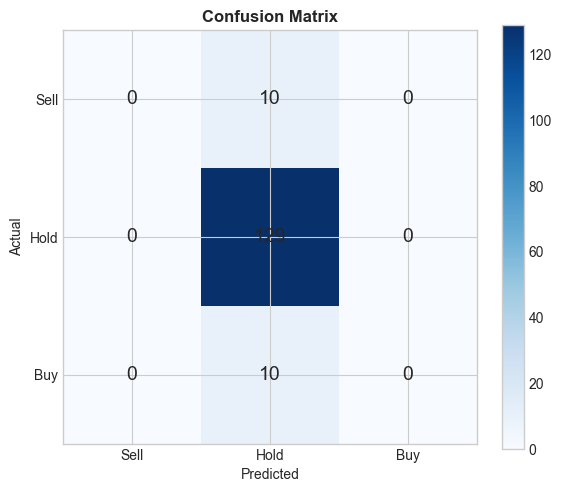

In [6]:
# ============================================================
# DAY 5: MULTICLASS CLASSIFICATION
# ============================================================

# Create 3-class labels
df['multiclass'] = pd.cut(df['return'].shift(-1), 
                          bins=[-np.inf, -0.01, 0.01, np.inf],
                          labels=[0, 1, 2])  # 0=Sell, 1=Hold, 2=Buy
df_multi = df.dropna()

X_multi = df_multi[features]
y_multi = df_multi['multiclass'].astype(int)

# Scale and split
X_multi_scaled = scaler.fit_transform(X_multi)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi_scaled, y_multi, test_size=0.3, shuffle=False
)

# Multiclass Logistic Regression (multinomial is now default)
multi_model = LogisticRegression(random_state=42, max_iter=1000)
multi_model.fit(X_train_m, y_train_m)

y_pred_m = multi_model.predict(X_test_m)
y_prob_m = multi_model.predict_proba(X_test_m)

print("📊 MULTICLASS CLASSIFICATION")
print("=" * 60)
print(f"\nAccuracy: {(y_pred_m == y_test_m).mean():.2%}")
print(f"\nClass Distribution:")
print(f"   Sell (0):  {(y_test_m == 0).sum():>4} ({(y_test_m == 0).mean():.1%})")
print(f"   Hold (1):  {(y_test_m == 1).sum():>4} ({(y_test_m == 1).mean():.1%})")
print(f"   Buy (2):   {(y_test_m == 2).sum():>4} ({(y_test_m == 2).mean():.1%})")

print("\nClassification Report:")
print(classification_report(y_test_m, y_pred_m, target_names=['Sell', 'Hold', 'Buy']))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test_m, y_pred_m)
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Sell', 'Hold', 'Buy'])
ax.set_yticklabels(['Sell', 'Hold', 'Buy'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix', fontweight='bold')
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
plt.colorbar(im)
plt.tight_layout()
plt.show()

---

# 📊 Day 6: Handling Class Imbalance

## Theory

### The Problem
Financial data is often imbalanced:
- Rare events (crashes, breakouts)
- Extreme returns underrepresented

### Solutions

**1. Resampling:**
- **Oversampling:** SMOTE (Synthetic Minority Over-sampling)
- **Undersampling:** Random undersampling

**2. Class Weights:**
$$w_k = \frac{n}{K \cdot n_k}$$

**3. Evaluation Metrics:**
- **Precision:** $\frac{TP}{TP + FP}$
- **Recall:** $\frac{TP}{TP + FN}$
- **F1-Score:** $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
- **AUC-ROC:** Area under ROC curve

---

📊 CLASS IMBALANCE HANDLING

Original Class Distribution:
   Normal (0):   474 (95.6%)
   Extreme (1):    22 (4.4%)

Comparison:
Method                 Recall (Extreme)  Precision (Extreme)
------------------------------------------------------------
No Weights                       0.00%               0.00%
Balanced Weights                 0.00%               0.00%


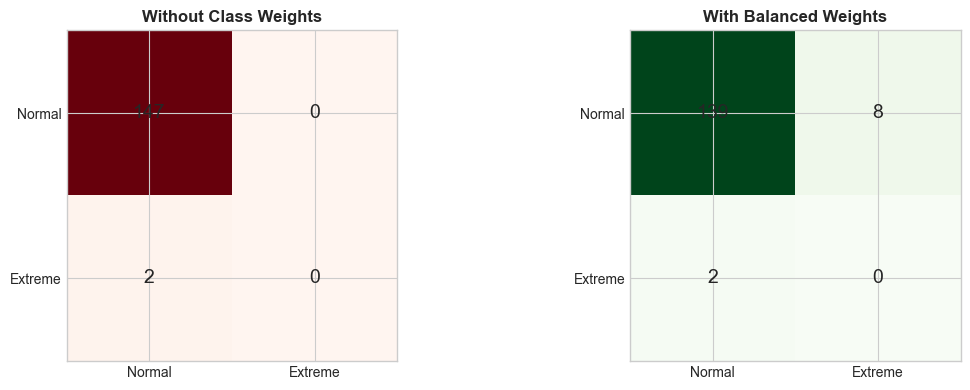

In [7]:
# ============================================================
# DAY 6: CLASS IMBALANCE
# ============================================================

from sklearn.utils.class_weight import compute_class_weight

# Create imbalanced scenario (extreme returns)
df['extreme'] = (np.abs(df['return'].shift(-1)) > 0.02).astype(int)
df_imb = df.dropna()

X_imb = df_imb[features]
y_imb = df_imb['extreme']

print("📊 CLASS IMBALANCE HANDLING")
print("=" * 60)
print(f"\nOriginal Class Distribution:")
print(f"   Normal (0): {(y_imb == 0).sum():>5} ({(y_imb == 0).mean():.1%})")
print(f"   Extreme (1): {(y_imb == 1).sum():>5} ({(y_imb == 1).mean():.1%})")

# Scale and split
X_imb_scaled = scaler.fit_transform(X_imb)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_imb_scaled, y_imb, test_size=0.3, shuffle=False
)

# Compare: No weights vs. Class weights
results_imb = {}

# Without class weights
model_no_weight = LogisticRegression(random_state=42)
model_no_weight.fit(X_train_i, y_train_i)
y_pred_nw = model_no_weight.predict(X_test_i)
results_imb['No Weights'] = {
    'recall_1': (y_pred_nw[y_test_i == 1] == 1).mean(),
    'precision_1': (y_test_i[y_pred_nw == 1] == 1).mean() if (y_pred_nw == 1).sum() > 0 else 0
}

# With class weights
model_weighted = LogisticRegression(class_weight='balanced', random_state=42)
model_weighted.fit(X_train_i, y_train_i)
y_pred_w = model_weighted.predict(X_test_i)
results_imb['Balanced Weights'] = {
    'recall_1': (y_pred_w[y_test_i == 1] == 1).mean(),
    'precision_1': (y_test_i[y_pred_w == 1] == 1).mean() if (y_pred_w == 1).sum() > 0 else 0
}

print("\nComparison:")
print(f"{'Method':<20} {'Recall (Extreme)':>18} {'Precision (Extreme)':>20}")
print("-" * 60)
for method, metrics in results_imb.items():
    print(f"{method:<20} {metrics['recall_1']:>17.2%} {metrics['precision_1']:>19.2%}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
cm_nw = confusion_matrix(y_test_i, y_pred_nw)
im1 = ax1.imshow(cm_nw, cmap='Reds')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Normal', 'Extreme'])
ax1.set_yticklabels(['Normal', 'Extreme'])
ax1.set_title('Without Class Weights', fontweight='bold')
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm_nw[i, j], ha='center', va='center', fontsize=14)

ax2 = axes[1]
cm_w = confusion_matrix(y_test_i, y_pred_w)
im2 = ax2.imshow(cm_w, cmap='Greens')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Normal', 'Extreme'])
ax2.set_yticklabels(['Normal', 'Extreme'])
ax2.set_title('With Balanced Weights', fontweight='bold')
for i in range(2):
    for j in range(2):
        ax2.text(j, i, cm_w[i, j], ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

---

# 📊 Day 7: Interview Review

## Common Interview Questions

### Q1: When to use Logistic Regression vs SVM?
**Answer:**
- **Logistic Regression:** When you need probability outputs, interpretable coefficients, baseline model
- **SVM:** When decision boundary is non-linear, high-dimensional data, robust to outliers

### Q2: Explain the Triple Barrier Method
**Answer:**
- Event-based labeling with 3 barriers: profit taking, stop loss, time
- Labels based on which barrier is touched first
- More realistic than fixed-horizon returns

### Q3: What is Meta-Labeling?
**Answer:**
- Two-stage approach: primary model (direction) + secondary model (bet sizing)
- Allows different optimization objectives for each stage
- Improves risk-adjusted returns

### Q4: How do you handle class imbalance?
**Answer:**
- Class weights (inverse frequency)
- SMOTE oversampling
- Appropriate metrics (F1, AUC-ROC)
- Cost-sensitive learning

---

## Summary Table

| Method | Pros | Cons | Use Case |
|--------|------|------|----------|
| Logistic | Interpretable, probabilities | Linear only | Baseline, probabilities |
| SVM | Non-linear, robust | No probabilities (default) | Complex boundaries |
| Triple Barrier | Realistic labels | Parameter tuning | Signal generation |
| Meta-Label | Bet sizing | Complexity | Position sizing |

---